# DIOMIRA

Leaving there and proceeding for three days toward the east, you reach Diomira, a city with sixty silver domes, bronze statues of all the gods, streets paved with lead, a crystal theater, a golden cock that crows every morning on a tower. All these beauties will already be familiar to the visitor, who has seen them also in other cities. But the special quality of this city for the man who arrives there on a September evening, when the days are growing shorter and the multicolored lamps are lighted all at once at the doors of the food stalls and from a terrace a woman's voice cries ooh!, is that he feels envy toward those who now believe they have once before lived an evening identical to this and who think they were happy, that time.

In [1]:
from __future__ import print_function

In [2]:
from IPython.display import Image

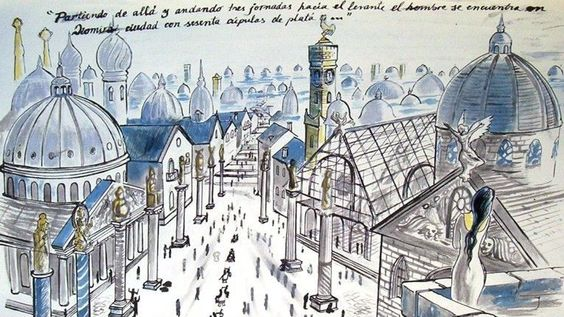

In [3]:
Image(filename='../../../Images/Diomira.jpg') 

In [1]:
import matplotlib
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML 
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [52]:
import Core.system_of_units as units
import Core.mplFunctions as mpl
import Core.wfmFunctions as wfm
import Core.tblFunctions as tbl
import Sierpe.FEE as FE
from scipy import signal

In [3]:
from Core.coreFunctions import wait

In [5]:
from Database import loadDB

In [6]:
import ICython.Core.system_of_units as SU

In [7]:
import cProfile

In [13]:
%load_ext Cython

In [8]:
import time

In [9]:
from nose.tools import *

### Diomira NB revisited on:

In [11]:
print(time.strftime("%d/%m/%Y"))

23/11/2016


In [12]:
print(time.strftime("%H:%M:%S"))

16:55:09


## Notes on DIOMIRA

### Role of DIOMIRA

Like all cities in IC, DIOMIRA consumes data to produce some new data. Specifically, DIOMIRA reads an hdf5 file containing MCRD (Monte Carlo Raw Data) for both the energy plane PMTs and the tracking plane SiPMs. 

MCRD represents the true response of sensors (PMTs and SiPMs) in NEXT. Each sensor reacts to the impinging light (primary en EL scintillation) by producing photoelectrons. The true response of the PMTs is described as a train or waveform of single photoelectrons (spe) in time bins of 1 ns. The true response of the SiPMs is described as a train of spes in bins of 1 mus.

The difference in time binning is related with differences in the electronics for PMTs and SiPMs. In the case of PMTs the ouput from the sensor (a current) is passed by the front-end PMT electronics (FEE-PMT) which can be described as the combination of a low-pass filters (LPF) which shapes and amplifies the signals, and a high-pass filter, associated with decoupling capacitor. 

See:
https://github.com/jjgomezcadenas/IC/blob/master/LabTools/DSP_sandbox_VHB.ipynb
https://github.com/jjgomezcadenas/IC/blob/master/Notebooks/SIERPE/SIERPE.ipynb

In the case of the SiPMs, the electronics is simpler (integration each 1 mus). 

The main action of DIOMIRA, then, is to read MCRD waveforms, simulate the response of the energy and tracking plane and produce raw waveforms (RWF) as well as base-line restored waveforms (BRL).

For the energy plane, RWF are the convolution of the MCRD with the LPF and HPF. The resulting function shows a negative swing associated with the differentiation introduced by the HPF. BLR functions are the convolution of the MCRD with the LPF only and correspond to an ideal case in which the RWF can be perfectly deconvoluted (.eg, base line restored). BLR are useful to compare with corrected waveforms (CWF) calculated later in the chain (by ISIDORA), where a real deconvolution algorithm is applied. In both cases, noise and the effect of DAQ is included. 

For the tracking plane, RWF correspond to add a realistic simulation of noise to the SiPMs. 

### Format

1. Diomira saves pmtrwf, sipmrwf and pmtblr wf as Int16, since those arrays correspond to the DAQ output (thus, adc counts). Using Int16 one can express up to 2**16, eg:

In [17]:
2**16

65536

Which is plenty to express the waveforms. 

2. The simulation of the WF is carried out using float64 (pyhton default) but one must convert to int before storing the waveforms. Round errors are negligible compared with both the scale and the noise, but the side effect is that the WF have many zeros which are effectively supressed by the compressor, thus saving space. 

3. If the function is stored as float, the zeros are not exact (e.g, numbers fluctuate around zero without being zero) and the compressor is not effective.

4. The difference in size is up to two orders of magnitude.

5. The simulation of pmtrwf and sipmrwf takes about 3 second/event and about 4.5 second/event adding the PMTBLR.

6. The space in disk is 350 kb/event (without BLR wfm) and 500 kb/event with blr 

### Code

#### PEP

In [13]:
!/Users/jjgomezcadenas/anaconda2/bin/pep8 ../../../Cities/DIOMIRA.py

In [14]:
!/Users/jjgomezcadenas/anaconda2/bin/pyflakes ../../../Cities/DIOMIRA.py

### Running DIOMIRA

In [16]:
ls -lh /Users/jjgomezcadenas/Documents/Development/NEXT/icdata/CalibElectrons/

total 1031240
-rw-r--r--  1 jjgomezcadenas  staff   185M Nov 18 12:54 electrons.1250.0keV.z250mm.next_1000.root.h5
-rw-r--r--  1 jjgomezcadenas  staff   263M Nov 18 12:55 electrons.2500.0keV.z250mm.next_1000.root.h5
-rw-r--r--  1 jjgomezcadenas  staff    56M Nov 18 12:55 electrons.40.0keV.z250mm.next_1000.root.h5


In [17]:
e40 =tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/CalibElectrons/electrons.40.0keV.z250mm.next_1000.root.h5','r+')

In [18]:
e40

File(filename=/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/CalibElectrons/electrons.40.0keV.z250mm.next_1000.root.h5, title='', mode='r+', root_uep='/', filters=Filters(complevel=0, shuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/pmtrd (EArray(1000, 12, 800000), zlib(4)) ''
  atom := Int16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 1, 32768)
/sipmrd (EArray(1000, 1792, 800), zlib(4)) ''
  atom := Int16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 50, 800)
/Detector (Group) ''
/Detector/DetectorGeometry (Table(1,)) ''
  description := {
  "x_det": Float32Col(shape=(2,), dflt=0.0, pos=0),
  "y_det": Float32Col(shape=(2,), dflt=0.0, pos=1),
  "z_det": Float32Col(shape=(2,), dflt=0.0, pos=2),
  "r_det": Float32Col(shape=(), dflt=0.0, pos=3)}
  byteorder := 'little'
  chunkshape := (2340,)
/MC (Group) ''
/MC/MCTracks (Table(4862,), zl

### Configuration file

In [19]:
ls /Users/jjgomezcadenas/Documents/Development/NEXT/IC/Config

ANASTASIA_default.conf     DOROTHEA_Na.conf
DIOMIRA_NA_ZLIB_test2.csv  DOROTHEA_default.conf
DIOMIRA_default.conf       ISIDORA_default.conf
DIOMIRA_test.csv           filter_example.conf
DOROTHEA_Kr.conf           filter_wrong_blr.conf


In [20]:
less /Users/jjgomezcadenas/Documents/Development/NEXT/IC/Config/DIOMIRA_default.conf

In [22]:
!echo $ICDIR

/Users/jjgomezcadenas/Documents/Development/NEXT/IC


In [33]:
%env ICONF=/Users/jjgomezcadenas/Documents/Development/NEXT/IC/Config/

env: ICONF=/Users/jjgomezcadenas/Documents/Development/NEXT/IC/Config/


In [34]:
!echo $ICDATA

/Users/jjgomezcadenas/Documents/Development/NEXT/icdata


In [35]:
!echo $ICONF

/Users/jjgomezcadenas/Documents/Development/NEXT/IC/Config/


In [36]:
!python ../../../Cities/DIOMIRA.py -c $ICONF/DIOMIRA_default.conf -i \
$ICDATA/CalibElectrons/electrons.40.0keV.z250mm.next_1000.root.h5 \
-o $ICDATA/CalibElectrons/electrons.40.keV.z250_100.RWF.h5 -n 10


Leaving there and proceeding for three days toward the east, you reach Diomira,
a city with sixty silver domes, bronze statues of all the gods, streets paved
with lead, a crystal theater, a golden cock that crows every morning on a
tower. All these beauties will already be familiar to the visitor, who has seen
them also in other cities. But the special quality of this city for the man who
arrives there on a September evening, when the days are growing shorter and the
multicolored lamps are lighted all at once at the doors of the food stalls and
from a terrace a woman's voice cries ooh!, is that he feels envy toward those
who now believe they have once before lived an evening identical to this and
who think they were happy, that time.

COMPRESSION            => ZLIB4
FILE_IN                => /Users/jjgomezcadenas/Documents/Development/NEXT/icdata/CalibElectrons/electrons.40.0keV.z250mm.next_1000.root.h5
FILE_OUT               => /Users/jjgomezcadenas/Documents/Development/NEXT/icdata/

In [37]:
ls -lh /Users/jjgomezcadenas/Documents/Development/NEXT/icdata/CalibElectrons

total 1036848
-rw-r--r--  1 jjgomezcadenas  staff   185M Nov 18 12:54 electrons.1250.0keV.z250mm.next_1000.root.h5
-rw-r--r--  1 jjgomezcadenas  staff   263M Nov 18 12:55 electrons.2500.0keV.z250mm.next_1000.root.h5
-rw-r--r--  1 jjgomezcadenas  staff    56M Nov 18 12:55 electrons.40.0keV.z250mm.next_1000.root.h5
-rw-r--r--  1 jjgomezcadenas  staff   2.7M Nov 23 17:22 electrons.40.keV.z250_100.RWF.h5


In [41]:
e40rwf =tables.open_file("/Users/jjgomezcadenas/Documents/Development/NEXT/icdata//CalibElectrons/electrons.40.keV.z250_100.RWF.h5",'r+')

In [42]:
e40rwf

File(filename=/Users/jjgomezcadenas/Documents/Development/NEXT/icdata//CalibElectrons/electrons.40.keV.z250_100.RWF.h5, title='', mode='r+', root_uep='/', filters=Filters(complevel=4, complib='zlib', shuffle=True, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/MC (Group) ''
/MC/FEE (Table(1,)) 'EP-FEE parameters'
  description := {
  "OFFSET": Int16Col(shape=(), dflt=0, pos=0),
  "CEILING": Int16Col(shape=(), dflt=0, pos=1),
  "PMT_GAIN": Float32Col(shape=(), dflt=0.0, pos=2),
  "FEE_GAIN": Float32Col(shape=(), dflt=0.0, pos=3),
  "R1": Float32Col(shape=(), dflt=0.0, pos=4),
  "C1": Float32Col(shape=(), dflt=0.0, pos=5),
  "C2": Float32Col(shape=(), dflt=0.0, pos=6),
  "ZIN": Float32Col(shape=(), dflt=0.0, pos=7),
  "DAQ_GAIN": Float32Col(shape=(), dflt=0.0, pos=8),
  "NBITS": Float32Col(shape=(), dflt=0.0, pos=9),
  "LSB": Float32Col(shape=(), dflt=0.0, pos=10),
  "NOISE_I": Float32Col(shape=(), dflt=0.0, pos=11),
  "NOISE_DAQ": Float32Col(shape=(), dflt=0.0, pos=1

In [43]:
DataPMT = loadDB.DataPMT()

In [44]:
DataPMT

,SensorID,ChannelID,PmtID,Active,X,Y,coeff_c,coeff_blr,adc_to_pes,noise_rms,sigma
0,0,0,1,1,-23.9414,65.7785,0.000003,0.001632,-24.3395,0.7060,7.73100
1,1,18,3,1,-44.9951,-53.6231,0.000003,0.001632,-24.8580,0.8744,8.82000
2,2,1,2,1,68.9365,-12.1554,0.000003,0.001611,-26.2934,0.7213,8.01375
3,3,19,4,1,0.0000,185.0000,0.000003,0.001599,-26.4110,0.7624,8.42224
4,4,27,C,1,-118.9160,141.7180,0.000003,0.001567,-26.7098,0.7921,6.23125
5,5,26,B,1,-182.1890,32.1249,0.000004,0.001650,-22.4456,0.8660,5.65180
6,6,9,A,1,-160.2150,-92.5000,0.000003,0.001593,-23.3552,0.7062,7.37840
7,7,8,9,1,-63.2737,-173.8430,0.000003,0.001612,-33.8821,0.7278,11.94840
8,8,23,8,1,63.2737,-173.8430,0.000003,0.001601,-21.8220,0.7303,6.11073
9,9,22,7,1,160.2150,-92.5000,0.000003,0.001593,-25.8020,0.7160,7.46200


### Checking pmtrwf and pmtblr

In [53]:
pmttwf, pmtrwf, pmtblr = tbl.get_pmt_vectors(e40rwf)

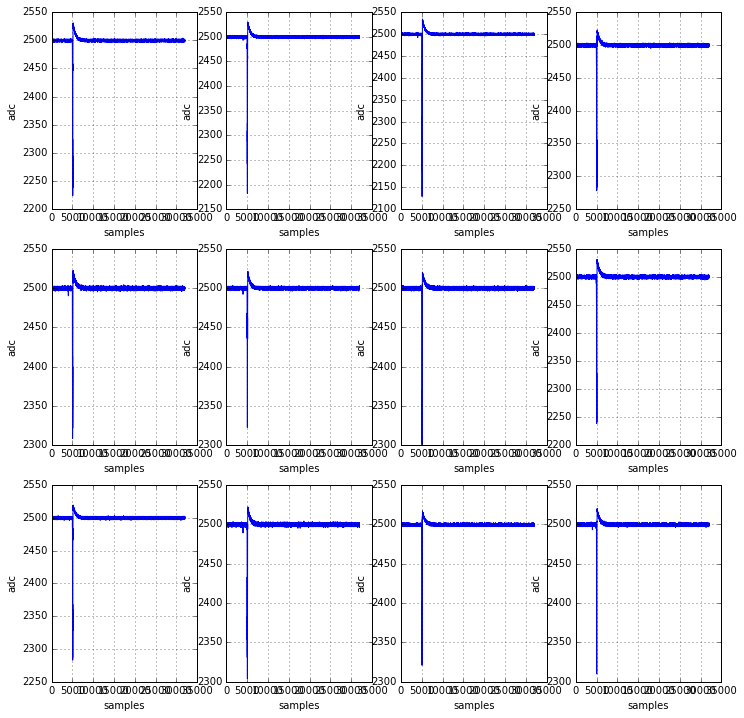

In [54]:
mpl.plot_waveforms(pmtrwf[0], maxlen=0, zoom=False, window_size=800)

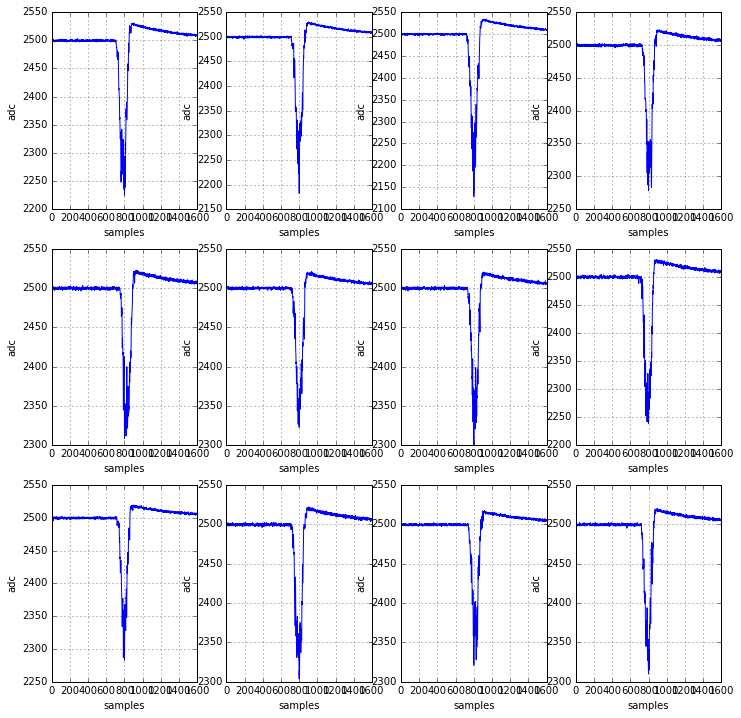

In [55]:
mpl.plot_waveforms(pmtrwf[0], maxlen=0, zoom=True, window_size=800)

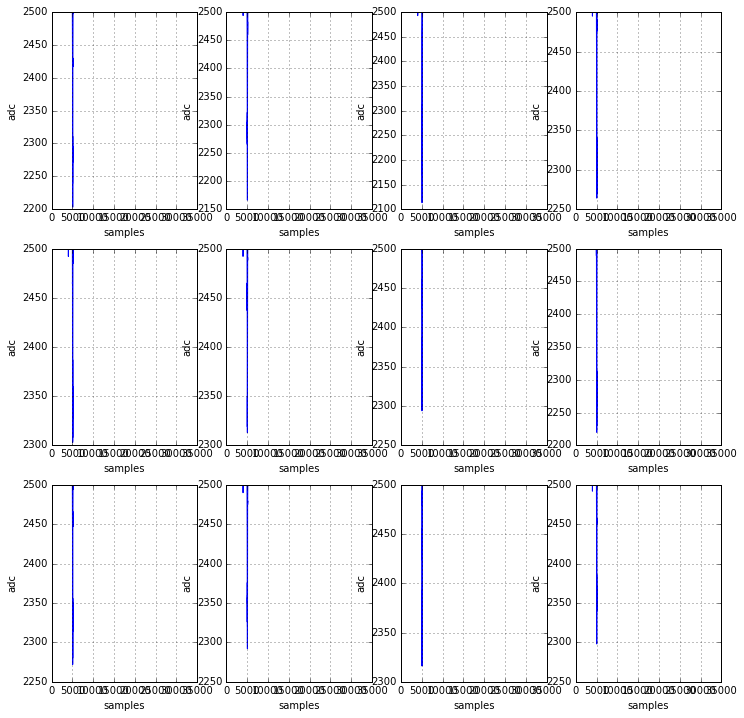

In [56]:
mpl.plot_waveforms(pmtblr[0], maxlen=0, zoom=False, window_size=800)

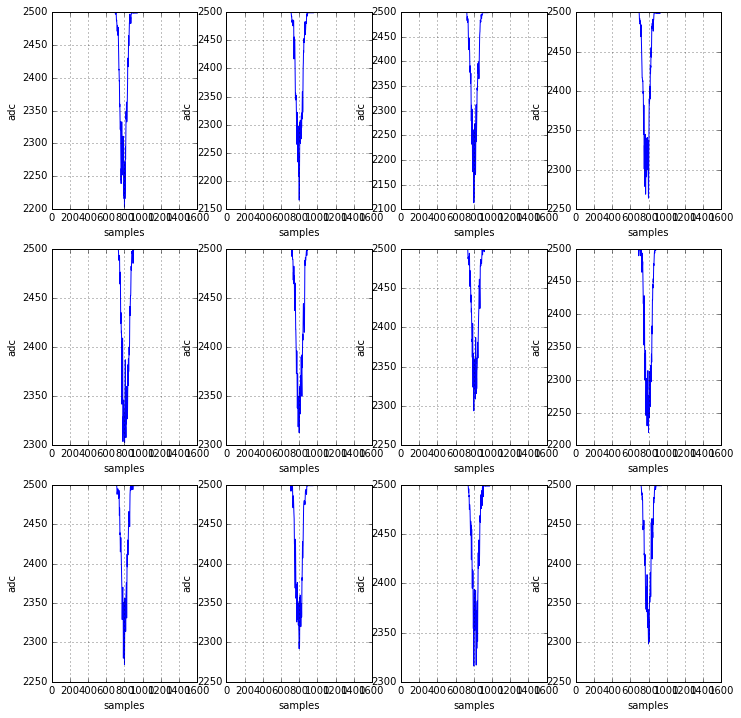

In [57]:
mpl.plot_waveforms(pmtblr[0], maxlen=0, zoom=True, window_size=800)

In [65]:
def get_energy_blr(pmtea, event_list=[0]):
    """
    Compute the sum of the waveforms for some events.

    Parameters
    ----------
    pmtea : tb.EArray
        The waveform (axis 2) for each sensor (axis 1) and event (axis 0).
    event_list : sequence of ints
        Event numbers.

    Returns
    -------
    wfes : pd.DataFrame
        Contains the sum of the waveform for each sensor indexed by ID.
    """
    NPMT = pmtea.shape[1]
    EPMT = []

    for i in event_list:
        epmt = np.zeros(NPMT)
        for j in range(NPMT):
            epmt[j] = np.sum(FE.OFFSET - pmtea[i, j])
        EPMT.append(epmt/FE.ADC_TO_PES)

    return pd.DataFrame(EPMT)

In [66]:
ene_blr = get_energy_blr(pmtblr, event_list=range(10))

In [60]:
ene_blr/20.

,0,1,2,3,4,5,6,7,8,9,10,11
0,3998934.10,3998950.95,3998785.05,3999185.10,3999223.40,3999313.60,3999300.30,3998962.30,3999326.30,3999244.35,3999401.00,3999311.60
1,3998893.70,3998871.45,3998818.45,3999217.40,3999136.20,3999254.25,3999290.50,3999025.20,3999342.15,3999224.75,3999394.25,3999341.45
2,3998907.70,3998885.70,3998810.95,3999187.35,3999200.80,3999310.30,3999271.70,3998867.70,3999333.65,3999234.95,3999404.90,3999371.85
3,3998969.65,3998935.95,3998898.20,3999150.60,3999176.25,3999342.35,3999285.60,3998934.45,3999340.85,3999245.45,3999411.15,3999330.55
4,3998935.80,3998896.95,3998851.05,3999194.45,3999185.95,3999360.20,3999340.35,3999042.60,3999308.60,3999236.75,3999414.35,3999355.45
5,3998917.10,3998856.75,3998797.65,3999213.15,3999194.75,3999322.90,3999294.00,3998922.70,3999358.55,3999266.05,3999385.50,3999328.80
6,3998925.10,3998926.30,3998812.80,3999203.00,3999217.00,3999276.05,3999304.65,3999018.60,3999331.15,3999249.10,3999389.75,3999326.60
7,3999013.60,3998949.30,3998877.90,3999210.45,3999247.00,3999350.50,3999339.10,3998946.90,3999303.95,3999232.45,3999395.55,3999351.80
8,3998888.65,3998938.30,3998857.50,3999286.25,3999213.40,3999324.10,3999325.95,3998970.90,3999380.25,3999200.20,3999425.10,3999311.55
9,3998967.15,3998925.85,3998807.75,3999177.75,3999159.50,3999270.25,3999294.50,3999002.65,3999329.15,3999185.15,3999394.60,3999334.10


In [ ]:
def true_energy(pmtblr, event_list=[0]):
    for event in event_list:
        

### Checking pmtrwf and pmtblr 

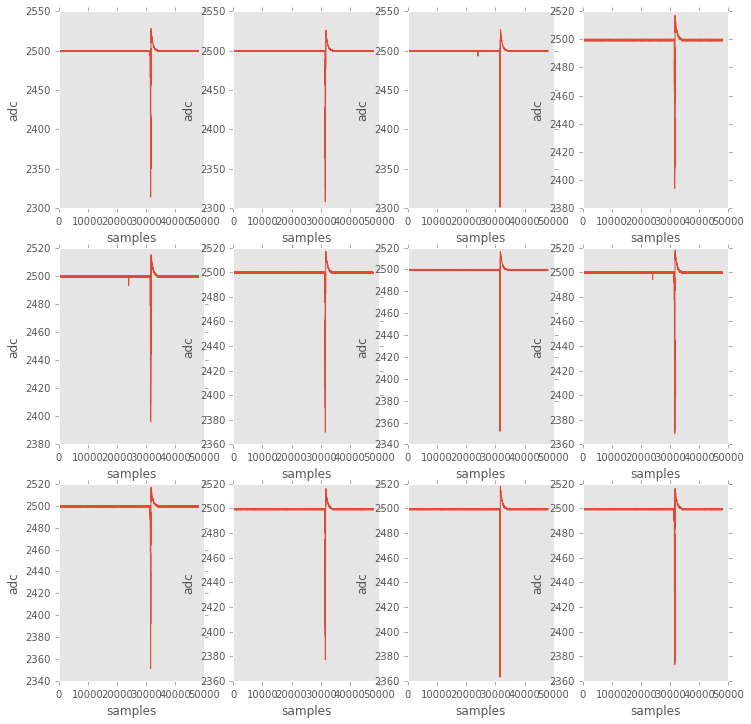

In [59]:
mpl.plot_waveforms(wfm.get_waveforms(pmtrwf,event_number=0))

In [60]:
pmtr0 = pmtrwf[0,0]

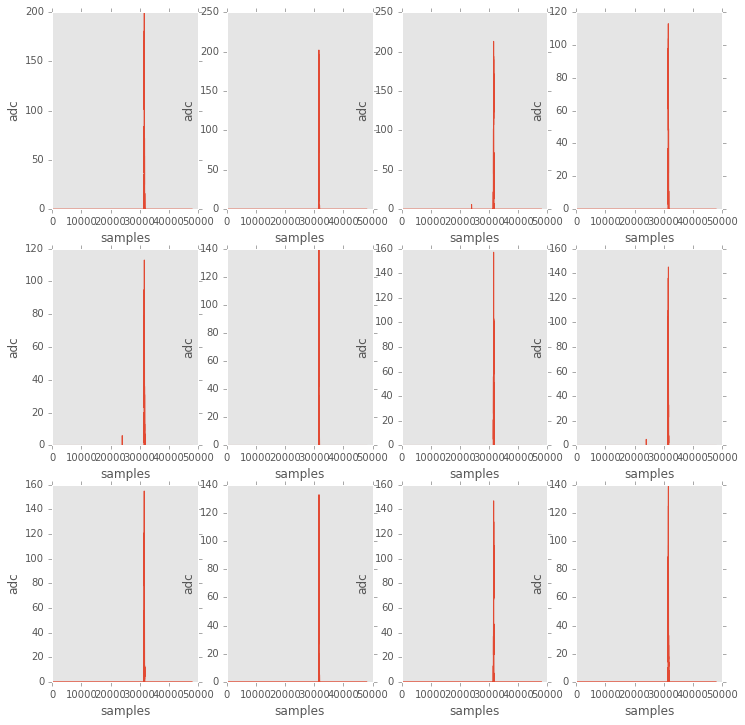

In [61]:
mpl.plot_waveforms(wfm.get_waveforms(pmtblr,event_number=0))

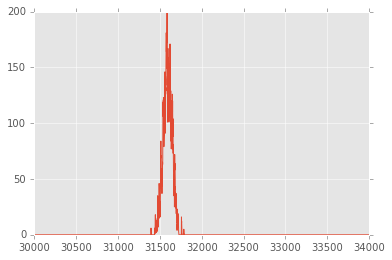

In [62]:
mpl.plts(pmtblr[0,0], signal_start=30000, signal_end=34000, offset=0)

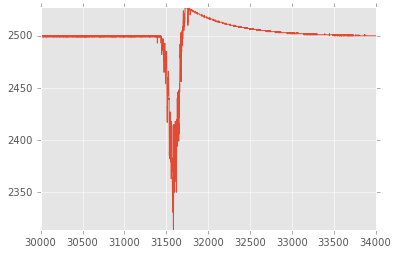

In [63]:
mpl.plts(pmtrwf[0,0], signal_start=30000, signal_end=34000, offset=0)

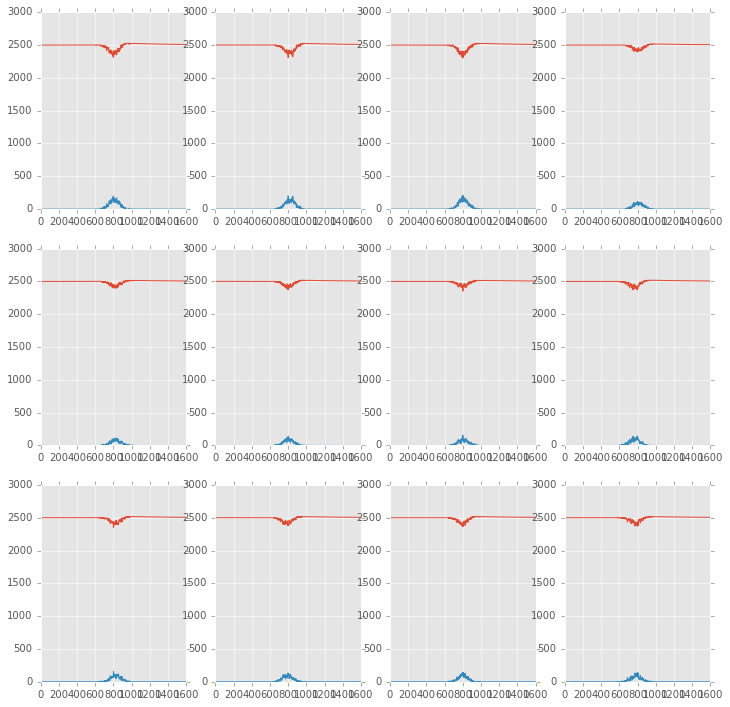

In [64]:
mpl.compare_raw_blr(pmtrwf, pmtblr, evt = 0, zoom = True, window_size = 800)

### True waveforms

In [26]:
pmttwf

/TWF/PMT (Table(120,), shuffle, zlib(1)) 'Store for PMTs TWF'
  description := {
  "event": UInt32Col(shape=(), dflt=0, pos=0),
  "ID": UInt32Col(shape=(), dflt=0, pos=1),
  "time_mus": Float32Col(shape=(), dflt=0.0, pos=2),
  "ene_pes": Float32Col(shape=(), dflt=0.0, pos=3)}
  byteorder := 'little'
  chunkshape := (4096,)
  autoindex := True
  colindexes := {
    "event": Index(6, medium, shuffle, zlib(1)).is_csi=False}

In [27]:
pmtp = tbl.read_wf_table(pmttwf, 0 )

works! We can access the data frames of the panel

In [28]:
pmtp

<class 'pandas.core.panel.Panel'>
Dimensions: 12 (items) x 1 (major_axis) x 2 (minor_axis)
Items axis: 0 to 11
Major_axis axis: 0 to 0
Minor_axis axis: ene_pes to time_mus

In [29]:
pmtp[11]

,ene_pes,time_mus
0,705.0,789782.6875


In [30]:
pmtp.items

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], dtype='int64')

In [31]:
pmtp[1]

,ene_pes,time_mus
0,1063.0,789637.0625


In [32]:
pmtp[1].sum().ene_pes

1063.0

In [33]:
def true_energy(sensorp):
    return sum(sensorp[i].ene_pes.values.sum() for i in sensorp.items)
    

In [38]:
def true_energy_distribution(pmttwf,event_list=range(10)):
    return np.array([true_energy(tbl.read_wf_table(pmttwf, event )) for event in event_list])
        

In [39]:
x = true_energy_distribution(pmttwf,event_list=range(10))


In [40]:
x

array([  9611.,   9137.,  10278.,   9602.,   9564.,   9669.,  10122.,
        10137.,   8096.,   8817.])

In [41]:
y = x[~np.isnan(x)]

In [42]:
y

array([  9611.,   9137.,  10278.,   9602.,   9564.,   9669.,  10122.,
        10137.,   8096.,   8817.])

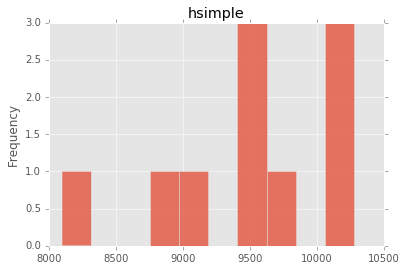

In [43]:
mpl.histo(y,10)

### SiPMs

In [83]:
def read_wf(table,event_number,isens):
    '''
        Reads table and returns the waveform (time_mus and ene_pes) corresponding
        to sensor isens of event event_number.
    '''
    try:
        return zip(*[ (row['time_mus'],row['ene_pes'])\
                     for row in table.iterrows() if row['event']== event_number and row['ID']== isens])
    except ValueError:
        logger.error('[read_wf]: empty sensor found: {}'.format(isens))


In [105]:
def wf2df(time_mus,energy_pes, dropnan=False):
    """
    takes two vectors (time, energy) and returns a data frame representing a waveform
    """
    if dropnan == False:
        return pd.DataFrame({'time_mus':time_mus,'ene_pes':energy_pes})
    else:
        return pd.DataFrame({'time_mus':time_mus,'ene_pes':energy_pes}).dropna()

In [114]:
def read_wf_table(table, event_number, dropnan=False):
    """
    Reads back the TWF of the PMTs/SiPMs for event number:
    input: the twf table of the PMTs,(SiPMs)  indexes and the event number
    outputs: a PMT/SiPM panel

    """
    sensor_list = set(table.read_where('event == {}'.format(event_number),field='ID'))
    print(sensor_list)
    wft = {}
    for isens in sensor_list:
        time, ene = read_wf(table,event_number,isens)
        df = wf2df(time, ene, dropnan=dropnan)
        print(df)
        wft[isens] = df.dropna()
    pdp = pd.Panel(wft)
    print(pdp[321])
    return pd.Panel(wft)


In [73]:
pmtp = read_wf_table( pmttwf, event_number=0 )

set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])


In [74]:
pmtp[1]

,ene_pes,time_mus
0,1063.0,789637.0625


In [75]:
sipmp = read_wf_table(sipmtwf, event_number=0 )

set([321, 322, 323, 324, 325, 329, 330, 331, 332, 333, 337, 338, 339, 340, 341, 346, 347, 348, 349, 122, 123, 124])


In [76]:
sipmp

<class 'pandas.core.panel.Panel'>
Dimensions: 22 (items) x 10 (major_axis) x 2 (minor_axis)
Items axis: 122 to 349
Major_axis axis: 0 to 9
Minor_axis axis: ene_pes to time_mus

In [77]:
sipmp.items

Int64Index([122, 123, 124, 321, 322, 323, 324, 325, 329, 330, 331, 332, 333,
            337, 338, 339, 340, 341, 346, 347, 348, 349],
           dtype='int64')

In [78]:
sipmp[122]

,ene_pes,time_mus
0,0.570168,787.0
1,0.866632,790.0
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
5,NaN,NaN
6,NaN,NaN
7,NaN,NaN
8,NaN,NaN
9,NaN,NaN


In [120]:
sipmp = read_wf_table(sipmtwf, event_number=0, dropnan=True)

set([321, 322, 323, 324, 325, 329, 330, 331, 332, 333, 337, 338, 339, 340, 341, 346, 347, 348, 349, 122, 123, 124])
    ene_pes  time_mus
0  2.926629     790.0
1  1.016609     791.0
    ene_pes  time_mus
0  0.989625     786.0
1  5.134616     787.0
2  1.713405     788.0
3  5.171690     789.0
4  7.467691     790.0
5  0.102719     791.0
     ene_pes  time_mus
0   0.937262     784.0
1   1.830109     786.0
2  15.137391     787.0
3  39.573372     788.0
4  19.500580     789.0
5  41.112606     790.0
6  20.442823     791.0
     ene_pes  time_mus
0   0.441508     786.0
1   5.999704     787.0
2  17.022896     788.0
3  14.124597     789.0
4  11.871054     790.0
5   1.919034     791.0
    ene_pes  time_mus
0  2.474795     786.0
1  3.194513     788.0
2  3.215134     789.0
3  0.412925     792.0
    ene_pes  time_mus
0  1.032387     788.0
1  1.839522     789.0
2  1.790622     791.0
     ene_pes  time_mus
0   0.836310     785.0
1   3.896551     786.0
2   1.703345     787.0
3  12.231436     788.0
4  15.

In [121]:
z = sipmp[321]

In [122]:
z

,ene_pes,time_mus
0,2.926629,790.0
1,1.016609,791.0
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
5,NaN,NaN
6,NaN,NaN
7,NaN,NaN
8,NaN,NaN
9,NaN,NaN


In [131]:
def clean_na(panel):
    nd = {}
    for i in panel.items:
        nd[i] = sipmp[i].dropna()
    return nd
    

In [132]:
z = clean_na(sipmp)

In [134]:
z[122]

,ene_pes,time_mus
0,0.570168,787.0
1,0.866632,790.0


In [130]:
z[122]

,ene_pes,time_mus
0,0.570168,787.0
1,0.866632,790.0
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
5,NaN,NaN
6,NaN,NaN
7,NaN,NaN
8,NaN,NaN
9,NaN,NaN


In [44]:
sipmp = tbl.read_wf_table(sipmtwf, 0 )

In [45]:
sipmp.items

<class 'pandas.core.panel.Panel'>
Dimensions: 22 (items) x 10 (major_axis) x 2 (minor_axis)
Items axis: 122 to 349
Major_axis axis: 0 to 9
Minor_axis axis: ene_pes to time_mus

In [49]:
sipmp.items

Int64Index([122, 123, 124, 321, 322, 323, 324, 325, 329, 330, 331, 332, 333,
            337, 338, 339, 340, 341, 346, 347, 348, 349],
           dtype='int64')

In [53]:
sipmp[321]

,ene_pes,time_mus
0,2.926629,790.0
1,1.016609,791.0
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
5,NaN,NaN
6,NaN,NaN
7,NaN,NaN
8,NaN,NaN
9,NaN,NaN


In [46]:
x = true_energy_distribution(sipmtwf,event_list=range(10))

In [47]:
x

array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan])

In [ ]:
sipmrwfp = wfm.read_twf(sipmrwf, pmt_list, event_number=1)

In [ ]:
def plot_best(sipmrwf,sipmtwf,sipmdf, evt = 0):
    '''
        Plot the noisy waveform of the SiPM with greatest charge and superimpose the true waveform.
    '''
    #Find SiPM with greatest peak
    maxsipm = np.unravel_index(sipmrwf[evt,:,:].argmax(),sipmrwf[evt,:,:].shape)[0]
    print("SiPM with greatest peak is at index {} with ID {}".format(maxsipm,sipmdf.ix[maxsipm].channel))
    # Plot noisy waveform in red and noiseless waveform in blue
    true_times, true_amps = zip(*[ (row['time_mus'],row['ene_pes']) for row in sipmtwfm.iterrows() if row['event'] == evt and row['sipm'] == maxsipm ])
    plt.plot(sipmrwf[evt,maxsipm,:])
    plt.plot(true_times,true_amps)

In [64]:
pmtp = read_sensor_twf(pmttwf, pmt_list, event_number=9)

In [65]:
pmtp

<class 'pandas.core.panel.Panel'>
Dimensions: 12 (items) x 1 (major_axis) x 2 (minor_axis)
Items axis: 0 to 11
Major_axis axis: 0 to 0
Minor_axis axis: ene_pes to time_mus

In [66]:
pmtp[1]

,ene_pes,time_mus
0,942.0,1063.665283


But what i

In [ ]:
PMT={ ipmt : wfm.wf2df(zip(*[ (row['time_mus'],row['ene_pes']) for row in pmttwfm.iterrows() if row['event']== event_number and row['pmt']== ipmt])) for ipmt in pmt_list }
#
for ipmt in pmt_list:
    time_mus, ene_pes = zip(*[ (row['time_mus'],row['ene_pes']) for row in pmttwfm.iterrows() if row['event']== event_number and row['pmt']== ipmt])
                             
    PMT[i] = wfm.wf2df(time_mus,energy_pes)
                             
                        

In [40]:
import sensorFunctions as snf

In [41]:
def get_vectors(h5f):
    """
    input: file pointer
    returns: data vectors
    """
    pmtrwf = h5f.root.RD.pmtrwf
    sipmrwf = h5f.root.RD.sipmrwf
    geom_t = h5f.root.Detector.DetectorGeometry
    pmt_t = h5f.root.Sensors.DataPMT
    sipm_t = h5f.root.Sensors.DataSiPM
    gdf = snf.read_data_geom(geom_t)
    pmtdf = snf.read_data_sensors(pmt_t)
    sipmdf = snf.read_data_sensors(sipm_t)
    return pmtrwf,sipmrwf,pmtdf,sipmdf,gdf


In [43]:
pmtrwf,sipmrwf,pmtdf,sipmdf,gdf = get_vectors(h5f)

In [44]:
pmtdf

,active,adc_to_pes,channel,gain,x,y
0,1,-22.916800,0,0.001641,-23.941401,65.778503
1,1,-23.750999,1,0.001623,-44.995098,-53.623100
2,1,-25.300800,2,0.000000,68.936501,-12.155400
3,1,-25.998400,3,0.000000,-0.000000,185.000000
4,1,-23.707399,4,0.001596,-118.916000,141.718002
5,1,-20.892700,5,0.001581,-182.188995,32.124901
6,1,-22.134001,6,0.000000,-160.214996,-92.500000
7,1,-33.099300,7,0.000000,-63.273701,-173.843002
8,1,-20.437700,8,0.001622,63.273701,-173.843002
9,1,-25.169800,9,0.001601,160.214996,-92.500000


In [ ]:
plot_pmtwf(PMTWF)

In [80]:
sipmr = sipmrwf[0]

In [109]:
def ene_sipm(sipmrwf, event_list=[0]):
    SIPM =[]
    for event in event_list:
        sipmrw = sipmrwf[event]
        ESIPM = []
        for i in range(sipmrwf.shape[1]):
            sipmw = sipmrw[i]
            xsum = np.sum(sipmw)
            if xsum > 0:
                ESIPM.append(xsum)
        SIPM.append(np.max(np.array(ESIPM)))
    return SIPM
                    

In [114]:
esipm = ene_sipm(sipmrwf, event_list=range(1000))

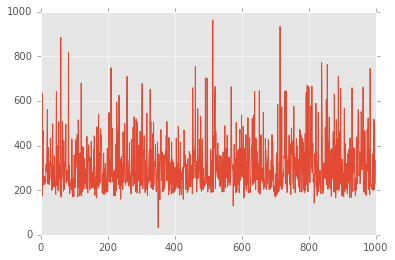

In [115]:
plt.plot(esipm)

In [116]:
np.average(esipm)

310.12219